In [ ]:
!pip install wandb

In [1]:
import pickle
with open('/content/drive/MyDrive/Gopal/Gopal_Xs.pkl', 'rb') as f:
    Xs = pickle.load(f)
with open('/content/drive/MyDrive/Gopal/Gopal_X_stat_s.pkl', 'rb') as f:
    X_stat = pickle.load(f)
with open('/content/drive/MyDrive/Gopal/Gopal_ys.pkl', 'rb') as f:
    ys = pickle.load(f)

In [1]:



import wandb


epochs = 3

wandb.login(key='abc123')
wandb.init(project="NeuralFactors", entity="jswc5233")  # Adjust names
wandb.config.update({"epochs": epochs, "learning_rate": 1e-4, "weight_decay": 1e-6})


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jswc5233. Use `wandb login --relogin` to force relogin


# Read data

In [ ]:
## log scale or std scale; some feature is better log scales
## sometimes normalize (std, make sure zero)
## flag - use alpha or not False

In [2]:
import torch
import numpy as np

flattened_Xs = [torch.tensor(X).view(-1, 16) for X in Xs]  # Flatten to (*, 14) (9xx, 5, 14)
all_X = torch.cat(flattened_Xs, dim=0)  # Shape: (total_samples, 14)

# Compute the max and min along the last dimension (14 features)
X_min = all_X.min(dim=0).values
X_max = all_X.max(dim=0).values

print("Global Min per feature:", X_min)
print("Global Max per feature:", X_max)

Global Min per feature: tensor([-9.2439e+03,  8.0000e-02,  1.0000e-02,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -5.3000e+03, -6.2430e+03, -1.4400e+04,
        -5.0840e+00, -5.0761e+05, -1.1806e+01, -1.1984e-01,  9.1400e+00,
        -2.0000e+01], dtype=torch.float64)
Global Max per feature: tensor([5.6626e+04, 9.9669e+01, 3.5490e+00, 2.0001e+06, 2.2698e+01, 1.6517e+05,
        1.2647e+02, 7.7400e+02, 1.0000e+00, 1.5350e+02, 2.3790e+00, 4.3896e+01,
        1.7008e+01, 9.3828e-02, 8.2690e+01, 3.6015e+04], dtype=torch.float64)


In [3]:
Xs_ = []
X_stat_s_ = []
ys_ = []

for X, x_stat, y in zip(Xs, X_stat, ys):
    X_tensor = torch.tensor(X)  # Shape: (N_t, 5, 14)
    x_stat_tensor = torch.tensor(x_stat) / torch.tensor([1, 1, 10, 100])
    y_tensor = torch.tensor(y)

    # Normalize X using global min and max (X_min and X_max) for each of the 14 features
    X_normalized = (X_tensor - X_min.unsqueeze(0).unsqueeze(0)) / (X_max.unsqueeze(0).unsqueeze(0) - X_min.unsqueeze(0).unsqueeze(0) + 1e-6)
    # `X_min.unsqueeze(0).unsqueeze(0)` now has shape (1, 1, 14), broadcasting across `N_t` and `5`

    # Append the normalized data to the lists
    Xs_.append(X_normalized)
    X_stat_s_.append(x_stat_tensor)
    ys_.append(y_tensor)

# Modeling

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_dim, static_dim, hidden_dim, d_factor):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_alpha = nn.Linear(hidden_dim + static_dim, 1)
        self.fc_beta = nn.Linear(hidden_dim + static_dim, d_factor)
        self.fc_sigma = nn.Linear(hidden_dim + static_dim, 1)
        self.fc_nu = nn.Linear(hidden_dim + static_dim, 1)

    def forward(self, stock_time_series, stock_static):
        # hidden - (num_layers * num_directions, batch_size, hidden_dim)
        _, (hidden, _) = self.lstm(stock_time_series)  # hidden: (1, N_t, hidden_dim)
        hidden = hidden.squeeze(0)  # Shape: (N_t, hidden_dim)

        combined = torch.cat([hidden, stock_static], dim=1)  # Shape: (N_t, hidden_dim + static_dim)
        alphas = self.fc_alpha(combined).transpose(0,1) # Shape: (1,N_t)
        betas = self.fc_beta(combined)  # (d_factor, N_t)
        sigmas = torch.exp(self.fc_sigma(combined)).transpose(0,1)  # Shape: (1,N_t), ensure positive
        nus = F.softplus(self.fc_nu(combined)).transpose(0,1) + 4  # Shape: (1,N_t), ensure finite kurtosis

        return alphas, betas, sigmas, nus


In [5]:
from torch.distributions import MultivariateNormal
from torch.linalg import cholesky, solve_triangular

def T_log_prob(z, mu, sigmas, nus): # sigma is standard deviation
      z = z - mu # (20,N_t) <-> (1,N_t) = (20, N_t)
      scaled_z = z / sigmas # (20,N_t) </> (1,N_t) = (20,N_t)
      maha_squareds = scaled_z**2 # (20,N_t)

      log_prob = ( torch.lgamma((nus + 1) / 2)  # (1,N_t)
                  - torch.lgamma(nus / 2) # (1,N_t)
                  - 0.5 * torch.log(nus * torch.pi) # (1,N_t)
                  - torch.log(sigmas) # (1,N_t)
                  - (nus + 1) / 2 * torch.log(1 + maha_squareds / nus) # (20, N_t)
      )
      return log_prob.sum(dim=1) # sum over stocks, (20,)

def T_log_prob_x_giv_z(r_future, pred_mean, sigmas, nus):
    res = r_future - pred_mean  # (20, N_t)
    scaled_res = res / (sigmas + 1e-6)  # Avoid division instability
    maha_squareds = scaled_res**2  # (20, N_t)

    log_prob = (
        torch.lgamma((nus + 1) / 2)
        - torch.lgamma(nus / 2)
        - 0.5 * torch.log(nus * torch.pi)
        - torch.log(sigmas)
        - (nus + 1) / 2 * torch.log(1 + maha_squareds / nus)
    )

    # Tensor log-probability for gradients
    total_log_prob = log_prob.sum(dim=1)  # (20,)

    # Scalars for monitoring/debugging
    maha_term = ((nus + 1) / 2 * torch.log(1 + maha_squareds / nus)).detach().sum().item()
    sigma_term = (-torch.log(sigmas)).detach().sum().item()

    return total_log_prob, maha_term, sigma_term

class FactorModelVAE(nn.Module):
    def __init__(self, d_ts, d_static, hidden_size=256, d_factor=4, num_samples=20):
        super(FactorModelVAE, self).__init__()
        self.lstm_model = LSTMModel(d_ts, d_static, hidden_size, d_factor)
        self.d_factor = d_factor
        self.num_samples = num_samples
        self.mu_z_prior = torch.zeros((1,d_factor))  # (1,d_factor)
        self.Sigma_z_prior = torch.ones((1,d_factor))  # (1,d_factor)
        self.nu_prior = nn.Parameter(torch.Tensor([5.0]*d_factor)) # (d_factor,)
        self.nu_prior.requires_grad = True

    def qzx_parameters(self, alphas, betas, sigmas, nus, r_future):
        Sigma_z_post_inv = torch.diag(1/self.Sigma_z_prior.squeeze(0)) + betas.T @ torch.diag(1/sigmas.squeeze(0)**2) @ betas
        L = cholesky(Sigma_z_post_inv)

        mu = self.mu_z_prior/self.Sigma_z_prior +  ((r_future-alphas)/sigmas) @ betas
        # Sigma_z^-=LL',Sigma_z=(LL')^-=L^'-L^-

        mu = mu.view(-1,1)
        mu = solve_triangular(L, mu, upper=False)
        mu = solve_triangular(L.T, mu, upper=True)
        return L, mu.squeeze(-1) # (d_factor,) since rsample will copy this shape

    def forward(self, time_series_data, static_features, r_future, Sigma_z):
        """
        r_future - (1,N_t)
        """
        alphas, betas, sigmas, nus = self.lstm_model(time_series_data, static_features) # (1,N_t), (N_t, d_factor), (1,N_t), (1,N_t)
        print('[[MONITOR]]', 'max_sigma', torch.max(sigmas).item(), 'Q3_sigma', torch.quantile(sigmas, 0.75).item(),'max_nu', torch.max(nus).item(), 'Q3_nu', torch.quantile(nus, 0.75).item(), 'z_nu', self.nu_prior)
        L, mu_z_post = self.qzx_parameters(alphas, betas, sigmas, nus, r_future)
        P = L@L.T


        mvn = MultivariateNormal(mu_z_post, precision_matrix=P)
        z_samples = mvn.rsample((20,)) # (20, d_factor)
        log_qzx = mvn.log_prob(z_samples) # (20,)


        log_pz = T_log_prob(z_samples, self.mu_z_prior, self.Sigma_z_prior, self.nu_prior) # (20,)
        predicted_mean = alphas + z_samples @ betas.T # (1,N_t)<+>(20,N_t)=(20,N_t)
        log_pxz, maha_term, sigma_term = T_log_prob_x_giv_z(r_future, predicted_mean, sigmas, nus)

        print('[[ELBO]]:', maha_term, '+', sigma_term,' + ',log_pxz.mean().item(),' - ', log_qzx.mean().item())

        return - torch.logsumexp(log_pxz + log_pz - log_qzx, dim=0) + torch.log(torch.tensor(self.num_samples, dtype=torch.float32)), maha_term, sigma_term, log_pxz.mean().item(), log_qzx.mean().item()


In [14]:
#Xs[0].shape

In [7]:
# Define the dimensions of your input data
d_ts = Xs[0].shape[2]  # Number of time-series features (e.g., financial ratios)
d_static = 4  # Number of static features (e.g., company information)
hidden_size = 256  # Hidden size for the LSTM
d_factor = 4  # Latent dimension size (number of latent factors) -
num_samples = 20

print('d_ts = ', d_ts)

def initialize_lstm_weights(lstm):
    for name, param in lstm.named_parameters():
        if 'weight' in name:
            nn.init.xavier_normal_(param)  # Xavier initialization for weights
        elif 'bias' in name:
            nn.init.constant_(param, 0)

# Instantiate the model
model = FactorModelVAE(d_ts=d_ts, d_static=d_static, hidden_size=hidden_size, d_factor=d_factor, num_samples=num_samples)
initialize_lstm_weights(model.lstm_model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

d_ts =  16


In [16]:



for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    Sigma_z = torch.ones((1,model.d_factor))
    for X, x_stat,y in zip(Xs, X_stat_s_, ys):
        X_ = torch.tensor(X, dtype=torch.float32)
        x_stat_ = torch.tensor(x_stat, dtype=torch.float32)
        y_ = torch.tensor(y, dtype=torch.float32)
        optimizer.zero_grad()

        loss, maha_term, sigma_term, log_pxz, log_qzx = model(X_, x_stat_, y_, Sigma_z)

        # Backward pass and optimization
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.lstm_model.parameters(), max_norm=.5)
        optimizer.step()

        running_loss += loss.item()

        wandb.log({
            "loss": loss.item(),
            "maha_term": maha_term,
            "sigma_term": sigma_term,
            "log_pxz": log_pxz,
            "log_qzx": log_qzx
        })

    avg_loss = running_loss / len(Xs)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

print('Yay!')

# Save model and optimizer state
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epoch + 1,  # Save the current epoch for resuming
    'loss': avg_loss     # Optionally save the loss for resuming
}, '/content/drive/MyDrive/simplemodel_3epoch.pth')




<ipython-input-16-250fcb37fd92>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_stat_ = torch.tensor(x_stat, dtype=torch.float32)


Streaming output truncated to the last 5000 lines.
[[MONITOR]] max_sigma 0.49936333298683167 Q3_sigma 0.027367003262043 max_nu 4.301972389221191 Q3_nu 4.012383460998535 z_nu Parameter containing:
tensor([5.6960, 5.6713, 5.5110, 5.5814], requires_grad=True)
[[ELBO]]: 13243.0244140625 + 4662.64208984375  +  2810.9462890625  -  23.206756591796875
[[MONITOR]] max_sigma 0.4917545020580292 Q3_sigma 0.02727028727531433 max_nu 4.301424503326416 Q3_nu 4.012345314025879 z_nu Parameter containing:
tensor([5.6961, 5.6714, 5.5111, 5.5815], requires_grad=True)
[[ELBO]]: 12307.0751953125 + 4664.275390625  +  2859.37646484375  -  22.94658660888672
[[MONITOR]] max_sigma 0.48144054412841797 Q3_sigma 0.027069352567195892 max_nu 4.300626754760742 Q3_nu 4.012338638305664 z_nu Parameter containing:
tensor([5.6962, 5.6715, 5.5112, 5.5816], requires_grad=True)
[[ELBO]]: 24399.21875 + 4667.7431640625  +  2258.23681640625  -  22.49331283569336
[[MONITOR]] max_sigma 0.4711129069328308 Q3_sigma 0.0269583687186241

# Visualize

In [8]:
# Load checkpoint
checkpoint = torch.load('/content/drive/MyDrive/simplemodel_3epoch.pth')

# Restore model and optimizer states
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.eval()

<ipython-input-8-2ff9168cb72f>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/simplemodel_3epoch.pth')


FactorModelVAE(
  (lstm_model): LSTMModel(
    (lstm): LSTM(16, 256, batch_first=True)
    (fc_alpha): Linear(in_features=260, out_features=1, bias=True)
    (fc_beta): Linear(in_features=260, out_features=4, bias=True)
    (fc_sigma): Linear(in_features=260, out_features=1, bias=True)
    (fc_nu): Linear(in_features=260, out_features=1, bias=True)
  )
)

In [9]:
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings):

    # Convert embeddings to NumPy for PCA
    embeddings_np = embeddings.cpu().detach().numpy()

    # Apply PCA to reduce dimensions to 2 for visualization
    pca = PCA(n_components=2)
    embeddings_pca = pca.fit_transform(embeddings_np)

    # Plot the PCA-reduced embeddings
    plt.figure(figsize=(8, 6))
    plt.scatter(embeddings_pca[:, 0], embeddings_pca[:, 1], c='blue', edgecolors='k', alpha=0.7)
    plt.title('PCA of LSTM Embeddings')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.grid(True)
    plt.show()


In [16]:
alphas, betas, sigmas, nus = model.lstm_model(stock_time_series=torch.tensor(Xs[0],dtype=torch.float32),
                                              stock_static=torch.tensor(X_stat_s_[0],dtype=torch.float32))


<ipython-input-16-9c7d962120be>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  stock_static=torch.tensor(X_stat_s_[0],dtype=torch.float32))


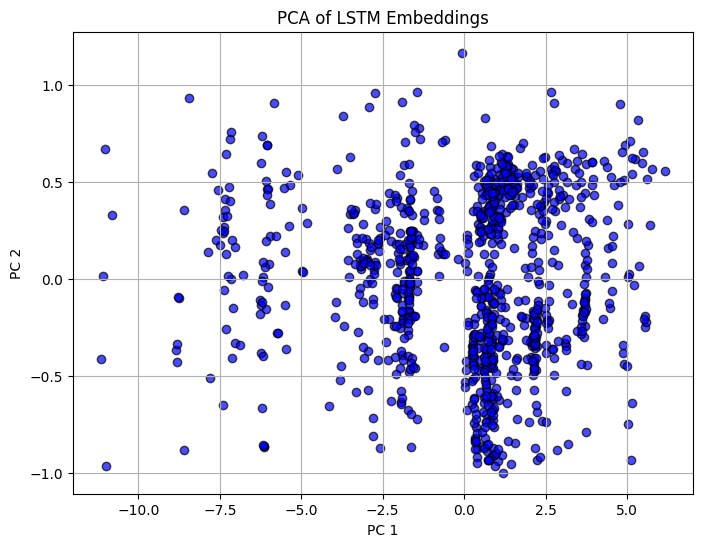

In [17]:
visualize_embeddings(betas)

In [20]:
all_factors = []

with torch.no_grad():
    for X_t, X_stat_t, y_t in zip(Xs, X_stat_s_, ys):
        X_t = torch.tensor(X_t, dtype=torch.float32)
        X_stat_t = torch.tensor(X_stat_t, dtype=torch.float32)
        y_t = torch.tensor(y_t, dtype=torch.float32)

        alphas, betas, sigmas, nus = model.lstm_model(X_t, X_stat_t)
        L, mu_z_post = model.qzx_parameters(alphas, betas, sigmas, nus, y_t)
        P = L @ L.T

        all_factors.append(mu_z_post)

all_factors = torch.stack(all_factors, dim=0)


<ipython-input-20-dcfcf6f89d01>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_stat_t = torch.tensor(X_stat_t, dtype=torch.float32)


In [22]:
all_factors.shape

torch.Size([3245, 4])

In [24]:
all_factors_cumsum = all_factors.cumsum(dim=0)
all_factors_exp = all_factors_cumsum.exp()

all_factors_exp.shape

torch.Size([3245, 4])

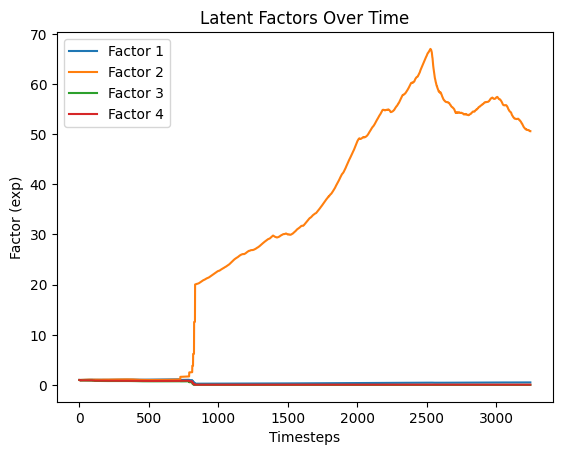

In [25]:
all_factors_cumsum = all_factors.cumsum(dim=0)
all_factors_exp = all_factors_cumsum.exp()

import matplotlib.pyplot as plt
for factor_idx in range(all_factors_exp.shape[1]):  # Loop over factors
    plt.plot(all_factors_exp[:, factor_idx].numpy(), label=f"Factor {factor_idx + 1}")
plt.title("Latent Factors Over Time")
plt.xlabel("Timesteps")
plt.ylabel("Factor (exp)")
plt.legend()
plt.show()